# "WxBS: Relaunching challenging benchmark for Image Matching"
> "And I mean really challenging"

- toc: false
- image: images/loftr_match.png
- branch: master
- badges: true
- comments: true
- hide: false
- search_exclude: false

## The hardest image matching benchmark

Previously we have discussed [what is WxBS in general](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/01/09/wxbs-in-simple-terms.html), [how to match images from a really different viewpoints](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2020/08/06/affine-view-synthesis.html) and also took a look into [Image Matching Challenge 2020](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/14/IMC2020-competition-recap.html). Let's now speak about how to measure progress on images, which are really hard to match even to human? 

For example, which have been taked in day-vs-night, years apart AND from different camera positions? One cannot register them to some 3d model, because they are too hard. And there is no 3D model either.

![](2021-07-28-Reviving-WxBS-benchmark_files/att_00001.png "Kyiv, Ukraine. Image pair from WxBS dataset")


Well, in that case one could go back to basics and *handlabel* the correspondences between the images. Such annotation is unlikely to be very precise, but it is going to be quite robust, if the labeler is careful. 


That is what I have done 6 years ago and published such a dataset at [BMVC 2015](http://www.bmva.org/bmvc/2015/papers/paper012/index.html) together with a benchmark of popular image matchers of that time. None of them was able to successfully match even a fraction of the WxBS dataset.

![](2021-07-28-Reviving-WxBS-benchmark_files/att_00002.png "Handlabeled correspondences in pixelstitch. The image in the bottom shows the correspondences and epipolar lines induced by them.")


However, as I was quite inexpereinced in product packaging, as well as in software engineering, the benchmark existed as dataset + bunch of bash and Matlab scripts. It is needless to say, that nobody evaluated their algorithms on it. 
That made me sad, however, I never found time to make this benchmark easy to use.
Well, now I did it and want to share the evaluation of the recent agorithms on such a hard data.


## Not that fast! Problem with a fundamental matrix and how to solve them


OK, we have ground truth correspondences. Now what? Ideally one can estimate epipolar geometry from as little, as 7 correspondences, but in practice? No. The problem is that there could be many relative camera poses, which are consistent with the correspondences, especially when correspondences lie in plane and the camera calibration is unknown. 

Let's consider a simple example: we have 13 correspondences and they seems to be correct. Are they enough for finding good epipolar geometry? This question can be answered via leave-one-out validation procedure, described in [VSAC paper](https://arxiv.org/abs/2106.10240). We remove a single correspondence, estimate a fundamental matrix via DLT algorithm on the rest of the correspondences and see how the estimated epipolar geometry is changed (or not).

As you can see on the animation below, the epipolar geometry estimation from our 13 correspondences is not stable and removing any of them results in noticable change. 

![](2021-07-28-Reviving-WxBS-benchmark_files/epi1.gif)


So, if even manually labeled corresposndences are not good enough, what can be done?

First, simply add more correspondences, which are spread across image AND depth levels as even as possible. That is what I did recently, in order to make WxBS labeling better. However, it is not always possible -- sometimes you have lots of correspondence on "faraway background plane" and very little somewhere on foreground, see next picture.

![](2021-07-28-Reviving-WxBS-benchmark_files/epi_harder.gif)

What else can be done? We can go other way round and *not provide any ground truth fundamental matrix at all*. 
Instead, we ask methods, which we evaluate, to give us such matrix *F_est*, then check, how many ground truth correspondences are consident with it. 

The bad thing about it, is that unless all 100% GT correspondences are consistent with *F_est*, *F_est* is completely wrong in terms of camera pose accuracy. So, such a binary signal on a very challenging pairs is not that useful. 
The good thing about it, is that if, say, 50% GT correspondences are consistent with *F_est*, it means that detected (not GT) correspondences *on the part of the image* are correct (e.g. on some dominant plane) and at least there we are OK. 

If you are interested in more mathematical definition, here it is:


The recall on ground truth correspondences $C_i$ of image pair $i$ and for geometry model $\mathbf{M}_i$ is computed as a function of a threshold $\theta$

\begin{equation}
 \mathrm{r}_{i,\mathbf{M}_i}(\theta) = \frac{| \{(\mathbf{u},\mathbf{v}) : (\mathbf{u},\mathbf{v}) \in C_i,  e(\mathbf{M}_i,\mathbf{u},\mathbf{v}) < \theta\}|}{| C_i |}
% \mathrm{r}_{i,\mathbf{M}_i}(\theta) = \frac{| \{(\mathbf{u}_i,\mathbf{v}_i) : (\mathbf{u}_i,\mathbf{v}_i) \in C_i,  e(\mathbf{M}_i,\mathbf{u},\mathbf{v}) < \theta\}|}{| C_i |}
\end{equation}

using [symmetric epipolar distance](https://kornia.readthedocs.io/en/latest/geometry.epipolar.html#kornia.geometry.epipolar.symmetrical_epipolar_distance). 

## Let's evaluate!

First I will show you how to run the WxBS benchmark yourself and then present the results I got.  Benchmark is available from pip:

In [ ]:
!pip install wxbs_benchmark
!pip install kornia_moons

Now we will write a simple function using OpenCV RootSIFT and [MAGSAC++](https://arxiv.org/abs/1912.05909). RootSIFT is a gold standard handcrafted local feature and MAGSAC++ is a state-of-the-art RANSAC, which is not sensitive to an inlier threshold, as [my recent benchmark](https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/17/OpenCV-New-RANSACs.html) shows. We will match then using mutual second nearest ratio, as implemented in [kornia](https://github.com/kornia/kornia)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import kornia.feature as KF
from kornia_moons.feature import *
from wxbs_benchmark.dataset import *
from wxbs_benchmark.evaluation import *
from tqdm import tqdm 

def sift2rootsift(desc):
    desc /= desc.sum(axis=1, keepdims=True) + 1e-8
    desc = np.sqrt(desc)
    return desc

def estimate_F_WithRootSIFT(img1, img2):
    det = cv2.SIFT_create(8000, contrastThreshold=-10000, edgeThreshold=10000)
    kps1, descs1 = det.detectAndCompute(img1, None)
    kps2, descs2 = det.detectAndCompute(img2, None)
    descs1 = sift2rootsift(descs1)
    descs2 = sift2rootsift(descs2)
    snn_ratio, idxs = KF.match_smnn(torch.from_numpy(descs1),
                                    torch.from_numpy(descs2), 0.95)
    tentatives = cv2_matches_from_kornia(snn_ratio, idxs)
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, inlier_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.25, 0.999, 100000)
    return F


subset = 'test'
dset = WxBSDataset('.WxBS', subset=subset, download=True)


F_results_RootSIFT = []

for pair_dict in tqdm(dset):
    current_F = estimate_F_WithRootSIFT(pair_dict['img1'], pair_dict['img2'])
    F_results_RootSIFT.append(current_F)

result_dict_rootsift, thresholds = evaluate_Fs(F_results_RootSIFT, subset)

We can check results for individual image pairs, or just take an average

dict_keys(['WGABS/kremlin', 'WGABS/kyiv', 'WGABS/strahov', 'WGABS/vatutin', 'WGALBS/bridge', 'WGALBS/flood', 'WGALBS/kyiv_dolltheater', 'WGALBS/rovenki', 'WGALBS/stadium', 'WGALBS/submarine', 'WGALBS/submarine2', 'WGALBS/tyn', 'WGALBS/zanky', 'WGBS/kn-church', 'WGLBS/alupka', 'WGLBS/berlin', 'WGLBS/charlottenburg', 'WGLBS/church', 'WGLBS/him', 'WGLBS/maidan', 'WGLBS/ministry', 'WGLBS/silasveta2', 'WGLBS/warsaw', 'WGSBS/kettle', 'WGSBS/kettle2', 'WGSBS/lab', 'WGSBS/lab2', 'WGSBS/window', 'WLABS/dh', 'WLABS/kpi', 'WLABS/kyiv', 'WLABS/ministry', 'average'])


/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


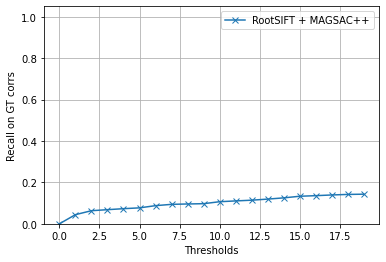

In [5]:
print(result_dict_rootsift.keys())
plt.figure()
plt.plot(thresholds, result_dict_rootsift['average'], '-x')
plt.ylim([0,1.05])
plt.xlabel('Thresholds')
plt.ylabel('Recall on GT corrs')
plt.grid(True)
plt.legend(['RootSIFT + MAGSAC++'])

I have run several popular recent methods in this [Colab](https://colab.research.google.com/drive/1yrCFyEoAc0HyqYCRVvzJDh5kQT2Dc3XA?usp=sharing). The code is very dirty, that is why I don't put it here, and just present results.

## Methods tested


### Local features without learned matching.

[RootSIFT](https://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf) (ICCV1999 - CVPR-2012), [DoG](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)+[HardNet](https://arxiv.org/pdf/1705.10872.pdf) (NeurIPS 2017), [R2D2](https://arxiv.org/abs/1906.06195) (NeurIPS 2019), [DISK](https://arxiv.org/abs/2006.13566) (NeurIPS 2020).


### Local features with learned matching.

[SuperGlue](https://arxiv.org/abs/1911.11763) (CVPR2020) uses attention-based graph neural network to match SuperPoint local features.

### Dense matching

[PDCNet](https://prunetruong.com/research/pdcnet) (CVPR 2021). On top of pretrained ImageNet coarse-to-fine feature correlation,  PDCNet predicts a dense flow and a confidence for each pixel. Trained on huge dataset with synthetic warps.

[Patch2pix](https://arxiv.org/abs/2012.01909) (CVPR 2021). Similarly to PDCNet, patch2pix is uses pretrained ImageNet features to get the initial corresponcences. Then the matches are progressively refined or rejected with a regressor network.

[DFM](https://arxiv.org/abs/2106.07791) (CVPRW 2021). Like PDCNet and Patch2pix, DFM uses ImageNet-pretrained and frozen VGGNet backbone as dense feature extractor. Unlike them, DFM does not requite any training and relies on simple handcrafted coarse-to-fine matching from conv5 to conv1. 


### Dense matching with transformers

[COTR](https://arxiv.org/abs/2103.14167), (ICCV2021). Given the pixel location in a query image, COTR finds a corresponing location in the reference image. It operated on the 16x16 feature map produced by pretrained ImageNet model, which then are fed together with a positional embeddings to a transformer-based regressor.
It is also the slowest method among evaluated - because you have to run it *per each pixel separately*, if want dense correspondences.

[LoFTR](https://zju3dv.github.io/loftr/) (CVPR2021). LoFTR is very similar to Patch2pix, with the difference of using transformer architecture to for both coarse initial matching and consequent refinement. 
The second difference, is that, unlike all other methods, which are using ImageNet-pretrained models as a feature backbone, LoFTR trains ResNet18 *from scratch* .


## Results & Discussion

![image.png](2021-07-30-Reviving-WxBS-benchmark_files/att_00000.png)




The clear leader is LoFTR, then we have (patch2pix, COTR and SuperGlue) group, followed by (PDCNet, DISK, R2D2). Then DoG-HardNet and RootSIFT, where latter has barely matched couple of image pairs correctly.

I have no idea, why LoFTR is so good, my guesses would be richer training data and training the backbone from scratch, instead of relying on ImageNet feaures. I am also quite surprised by the great performance of the patch2pix, which probably can be improved even more, if the backbone would be at least fine-tuned.

Another surprise is a great performance of the DFM matcher, which is slightly better than PDCNet and worse (but comparable) than COTR. My hypothesis is that all this methods rely on the same ImageNet backbone: if they fail, all the methods fail.

Regarding SuperGlue - one of my guesses is that original SuperPoint features were not trained for different illuminations. Moreover, in some images, there just not enough matching corners -  when I was annotating the correspondences, I have to use also "center of the blobs".


Finally, I would like to that than even excellent LofTR result is far from the ideal -- there are stil tens of pairs, where it fails. 

P.S. I would also like to thank Prune Truong and Ufuk Efe who helped me to debug my originally wrong run of the PDCNet and DFM respectively.


### Qualiative examples

Here are some examples of how different methods work on the same image pairs.

### Season + viewpoint

LoFTR

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00006.png)

SuperGlue

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00007.png)

patch2pix

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00008.png)

### Thermal vs visible + viewpoint 


LoFTR

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00011.png)

SuperGlue

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00010.png)

patch2pix

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00009.png)

### Season + illumination + viewpoint

LoFTR

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00014.png)

SuperGlue

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00016.png)

patch2pix

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00017.png)


### Illumination + viewpoint change (zoom)

LoFTR

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00018.png)


SuperGlue
![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00019.png)


patch2pix

![image.png](2021-07-28-Reviving-WxBS-benchmark_files/att_00020.png)

As you can, see, there are many incorrect correspondences even in those images, where methods are performing well.

Here I will conclude and go to vacation.

In the 2nd part of the post, I would like to evaluate COTR, PDCNet and different dense descriptors directly on the GT correspondences, by giving a point in image A and asking for point in image B. 